In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [146]:
# necessario creare una cartella dati fuori da questa
magistrale= pd.DataFrame(pd.read_excel("../dati/iscritti_magistrale_informatica.xls")) 
triennale= pd.DataFrame(pd.read_excel("../dati/iscritti_triennale_informatica.xls")) 
piani= pd.DataFrame(pd.read_excel("../dati/piani_informatica.xls"))

In [147]:
triennale.head()

,PROGRESSIVO,GENERE,CODCLA,DECO_CLA,ANAC_LAUREA,VOTO_LAUREA,BASE_LAUREA,DATA_LAUREA,ANAC_INGRESSO,ANAC_USCITA,PERIODI_MOBILITA,SITUAZIONE_FINALE,ANAC_RINUNCIA,ANNO_DIPLOMA,MEDIA_DIPLOMA,BASE_DIPLOMA,DIPLOMA_LODE,TIPO_ISTITUTO,PROVINCIA_DIPLOMA,STATO_DIPLOMA
0,129859,M,8759,INFORMATICA,NaN,NaN,NaN,NaT,2010,2010,0,ATTIVO,NaN,1994,36.0,60.0,NaN,IST.TEC. IND. ST.,GENOVA,
1,132793,M,8759,INFORMATICA,NaN,NaN,NaN,NaT,2023,2023,0,ATTIVO,NaN,1994,44.0,60.0,NaN,IST.PROF.IND.ART.ST.,GENOVA,
2,148682,M,8759,INFORMATICA,2018.0,111.0,110.0,2019-07-24,2013,2018,0,ATTIVO,NaN,1996,36.0,60.0,NaN,LICEO SCIENT. ST.,GENOVA,ITALIA
3,158085,M,8759,INFORMATICA,NaN,NaN,NaN,NaT,2011,2011,0,ATTIVO,NaN,1996,50.0,60.0,NaN,LICEO SCIENT. ST.,SAVONA,ITALIA
4,190048,M,8759,INFORMATICA,NaN,NaN,NaN,NaT,2011,2011,0,ATTIVO,NaN,2002,100.0,100.0,NaN,LICEO CLASSICO ST.,GENOVA,


In [148]:
# percentuale donne in triennale: 14.4
print((triennale['GENERE'] == 'F').mean() * 100)

14.436363636363636


In [149]:
# join triennale
pt = pd.merge(piani, 
              triennale[['PROGRESSIVO', 'CODCLA', 'GENERE', 'ANAC_INGRESSO', 'ANAC_USCITA','DATA_LAUREA','SITUAZIONE_FINALE']], 
              how="right", 
              left_on=["PROGRESSIVO", "CODCLA"], 
              right_on=["PROGRESSIVO", "CODCLA"])

In [150]:
# pulizia dati

# elimino in piani_triennali i valori in cui ho NaN in CODICE_INS e DECODIFICA_INS
pt.dropna(subset=['CODICE_INS', 'DECODIFICA_INS'], how='all', inplace=True)

# miglioro leggibilità
pt['CODCLA'] = pt['CODCLA'].astype(int)
pt['CODICE_INS'] = pt['CODICE_INS'].astype(int)
pt['VOTO'] = pt['VOTO'].astype(int)

# elimino colonna rindondante (codcla separa triennale e magistrale)
pt['CODCLA'].unique()
pt.drop(columns=['CODCLA'], inplace=True)

# elimino insegnamenti con meno di 50 partecipanti (molti a scelta con solo 1 persona)
pt = pt[pt.groupby('DECODIFICA_INS')['PROGRESSIVO'].transform('size') >= 50] # -- osservare cambiamenti al variare di min

# non ho voti inferiori al 18 -- notificare
#print(pt['VOTO'].min())

# elimino i voti maggiori di 32 - perchè non so cosa siano, per ora --notificare
pt = pt[pt['VOTO'] <= 32]

A cosa si riferiscono i voti maggiori di 32?

In [151]:
# per ogni esame passato percentuale di donne

# numero studenti
n_studenti = pt['PROGRESSIVO'].nunique()
# numero studenti per esame
n_studenti_per_esame = pt.groupby('DECODIFICA_INS').size()
# percentuale studenti per esame, su quelli nel database
perc = (n_studenti_per_esame / n_studenti) *100
# percentuale donne per esame
n_donne_per_esame = pt[pt['GENERE'] == 'F'].groupby('DECODIFICA_INS').size()
perc_donne = ((n_donne_per_esame / n_studenti_per_esame) * 100)#.astype(int)


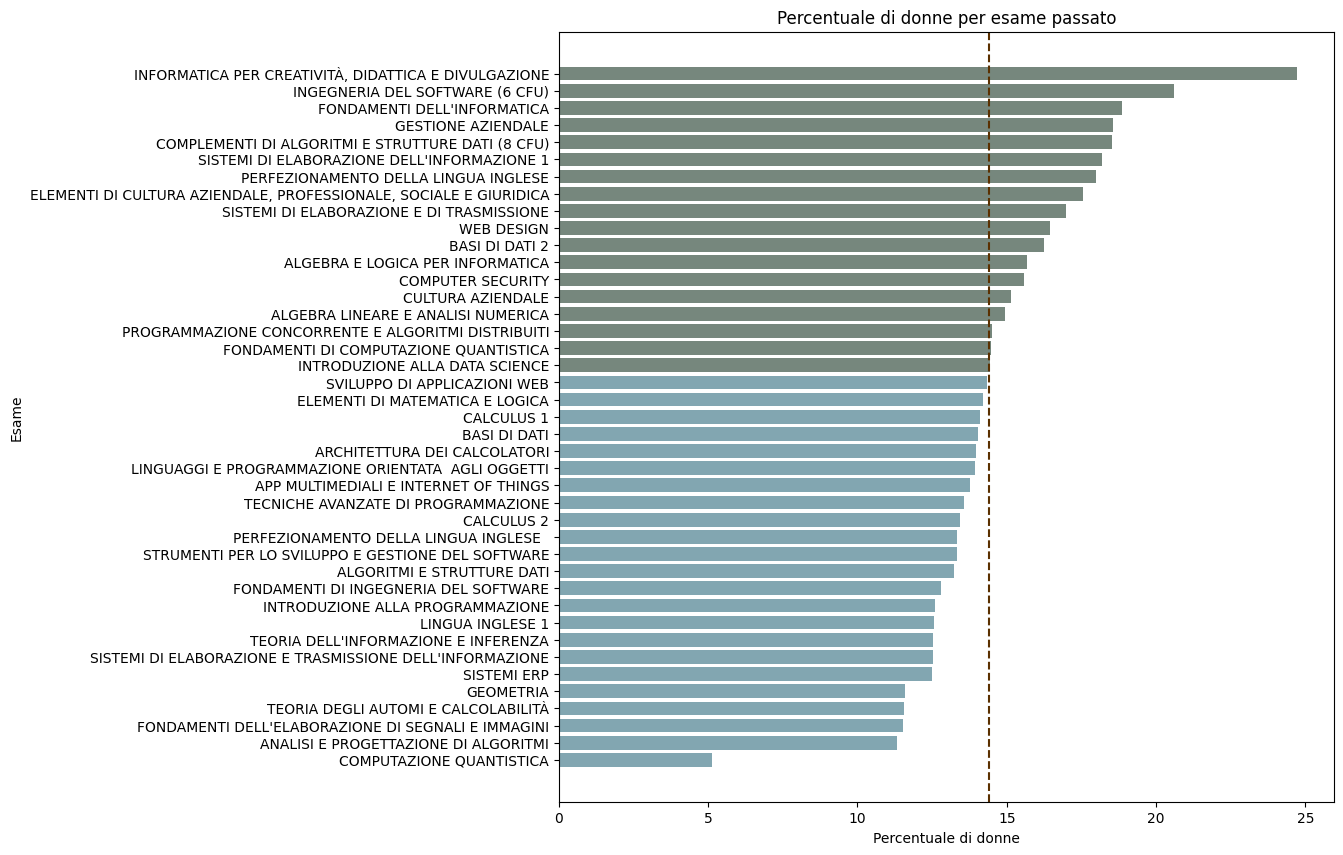

In [152]:
# visualizzazione percentuale di donne sul numero totale, di persone che hanno superato l'esame

perc_donne_sorted = perc_donne.sort_values()
colors = ['#82A6B1' if val < 14.4 else '#76877D' for val in perc_donne_sorted]
plt.figure(figsize=(10, 10))
bars = plt.barh(perc_donne_sorted.index, perc_donne_sorted, color=colors)
plt.axvline(x=14.4, color='#5B3000', linestyle='--')
plt.xlabel('Percentuale di donne')
plt.ylabel('Esame')
plt.title('Percentuale di donne per esame passato')
plt.show()

### percentuale di donne sul numero totale, di persone che hanno superato l'esame

Il numero di donne in questo database è il 14,4%, uso questo dato come soglia <br>
Osservo che esistono esami in favore e sfavore di entrambi i sessi, non posso assumere molto <br>

In [153]:
# la percentuale del numero di voti delle donne
totale_voti = len(pt)  # non ci sono null #print(pt['CODICE_INS'].isnull().sum()) #print(pt['VOTO'].isnull().sum())
totale_voti_donne = len(pt[pt['GENERE'] == 'F']) 
(totale_voti_donne/totale_voti)*100

13.846869909239004

### percentuale del numero di voti delle donne rispetto agli uomini
percentuale di voti leggermente più bassa del numero di donne, posso assumere che si fermino prima degli uomini nel percorso?

In [154]:
# analizzo l'andamento generale dei voti per ogni esame (solo chi ha passato l'esame)
perc_voti = ((pt.groupby('VOTO').size()) / (totale_voti)) * 100

In [155]:
# analizzo l'andamento per le donne dei voti
perc_voti_donne = ((pt[pt['GENERE'] == 'F'].groupby('VOTO').size()) / (totale_voti_donne)) * 100

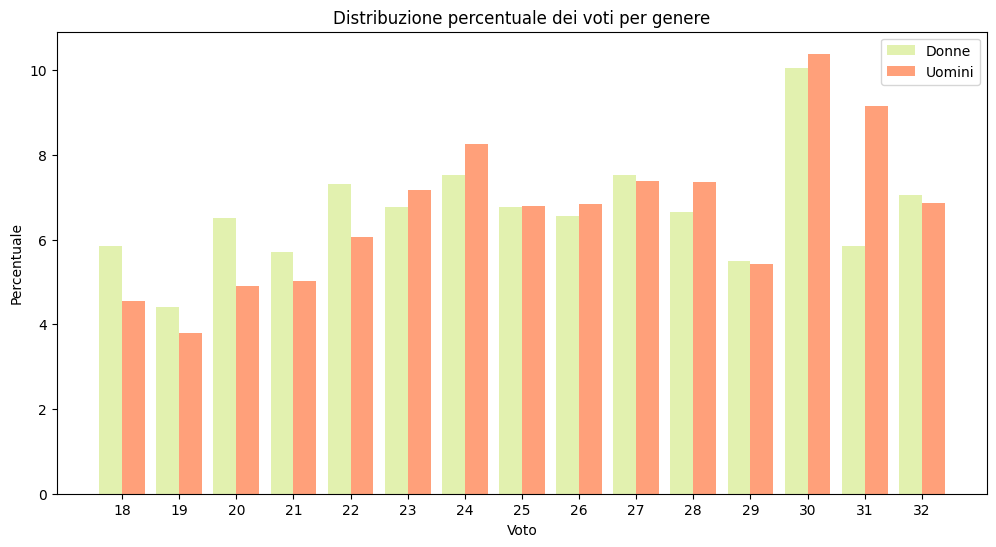

In [156]:
# visualizzazione della percentuale dei voti per genere

totale_voti_donne = len(pt[pt['GENERE'] == 'F'])
totale_voti_uomini = len(pt[pt['GENERE'] == 'M'])
voti_donne = pt[pt['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = pt[pt['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label='Donne', color='#E2F1AF')
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label='Uomini', color='#FFA07A')
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


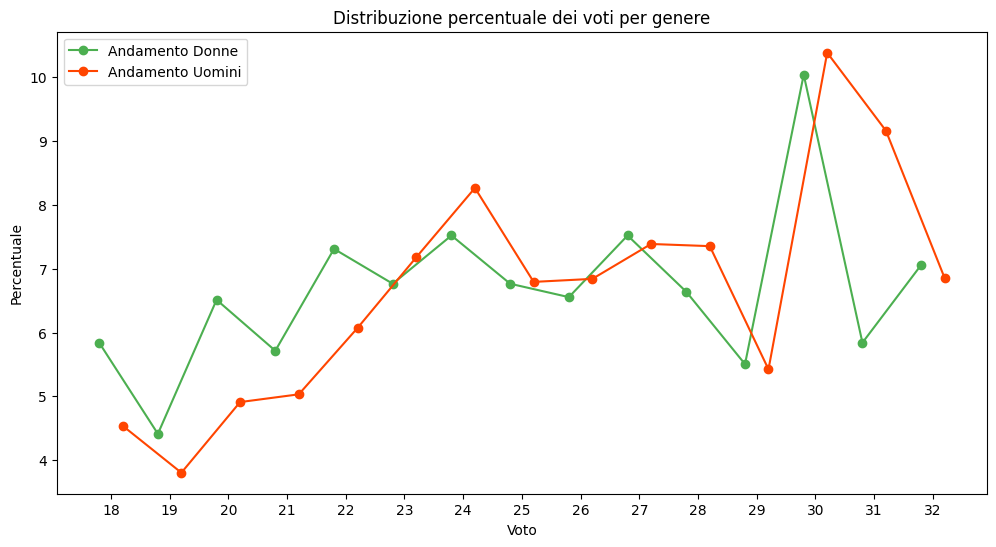

In [157]:
plt.figure(figsize=(12, 6))
plt.plot(r1, percentuale_voti_donne, marker='o', color='#4CAF50', label='Andamento Donne')
plt.plot(r2, percentuale_voti_uomini, marker='o', color='#FF4500', label='Andamento Uomini')
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere')
plt.legend()
plt.show()

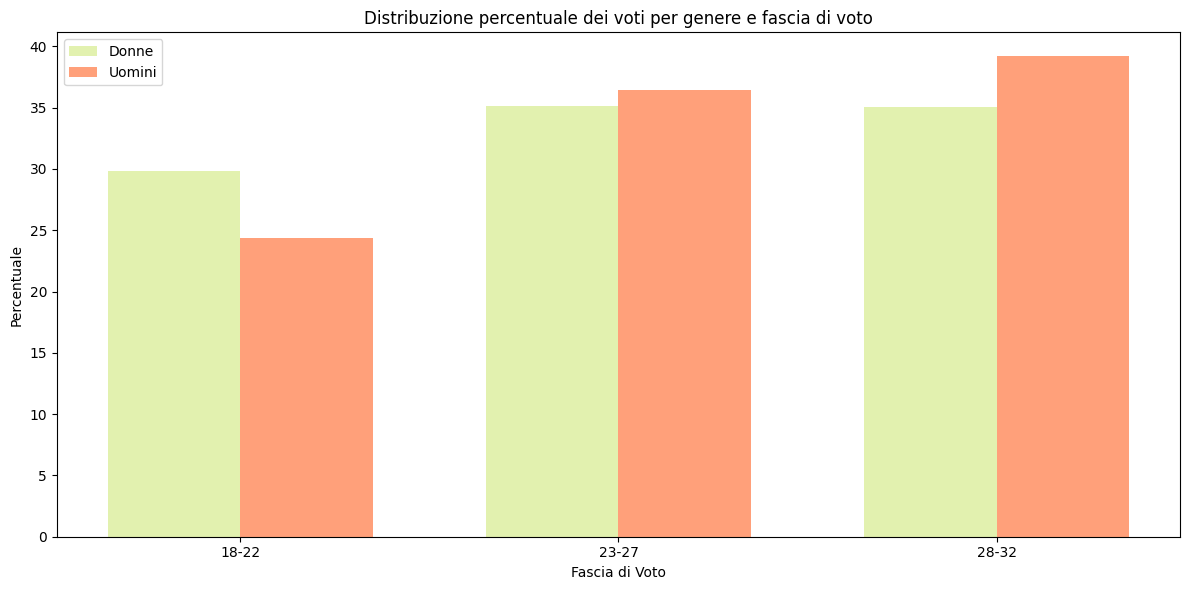

In [158]:
def categorize_voto(voto):
    if voto >= 18 and voto <= 22:
        return '18-22'
    elif voto >= 23 and voto <= 27:
        return '23-27'
    elif voto >= 28 and voto <= 32:
        return '28-32'
    else:
        return 'Altro'

pt['FASCIA_VOTO'] = pt['VOTO'].apply(categorize_voto)
totale_voti = pt.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label='Donne', color='#E2F1AF', width=bar_width)
plt.bar(r2, percentuali_uomini, label='Uomini', color='#FFA07A', width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()


### Percentuale di voti per ogni esame, divisi per genere
Osservo che le donne prediligono voti inferiori rispetto agli uomini

In [159]:
pt.head()

,PROGRESSIVO,CODICE_INS,DECODIFICA_INS,CFU,DATA_ESAME,VOTO,DESCRIZIONE_VOTO,GENERE,ANAC_INGRESSO,ANAC_USCITA,DATA_LAUREA,SITUAZIONE_FINALE,FASCIA_VOTO
2,148682,80298,ALGORITMI E STRUTTURE DATI,12.0,2014-07-30,27,ventisette,M,2013,2018,2019-07-24,ATTIVO,23-27
3,148682,67425,ARCHITETTURA DEI CALCOLATORI,12.0,2014-09-26,30,trenta,M,2013,2018,2019-07-24,ATTIVO,28-32
4,148682,57069,CALCULUS 1,6.0,2016-09-15,30,trenta,M,2013,2018,2019-07-24,ATTIVO,28-32
5,148682,80299,INTRODUZIONE ALLA PROGRAMMAZIONE,12.0,2014-04-10,29,ventinove,M,2013,2018,2019-07-24,ATTIVO,28-32
6,148682,73026,ELEMENTI DI MATEMATICA E LOGICA,12.0,2016-02-09,28,ventotto,M,2013,2018,2019-07-24,ATTIVO,28-32


In [160]:
def categorizza(row):
    if pd.notnull(row['DATA_LAUREA']):
        return 'laurea'
    elif (row['SITUAZIONE_FINALE'] == 'BLOCCO CARRIERA PER MANCATO PAGAMENTO (CC/VIRTUALE)') or \
         (row['SITUAZIONE_FINALE'] == 'ISCRIZIONE NON ATTIVA PER CARRIERA APERTA') or \
         (row['SITUAZIONE_FINALE'] == 'RINUNCIATARIO') or \
         (row['SITUAZIONE_FINALE'] == 'CONGEDATO') or \
         (row['SITUAZIONE_FINALE'] == 'INTERRUZIONE DEGLI STUDI') or \
         (row['SITUAZIONE_FINALE'] == 'SOSPESO RISERVA MOB.INT.'):
        return 'non laurea'
    elif (row['SITUAZIONE_FINALE'] == 'ATTIVO') or \
         (row['SITUAZIONE_FINALE'] == 'MANCATO PAGAMENTO I/II RATA ') or \
         (row['SITUAZIONE_FINALE'] == 'ANNO DI CORSO SOTTO CONDIZIONE'):
        return 'in esecuzione'
    else:
        return 'non laurea'

pt_laurea = pt.copy()
pt_laurea['CATEGORIA'] = pt_laurea.apply(categorizza, axis=1)

In [161]:
# analizzo il numero di donne laureate

print("Ricordiamo che la percentuale di donne è il 14%")

n_donne_laurea = pt_laurea[(pt_laurea['GENERE'] == 'F') & (pt_laurea['CATEGORIA'] == 'laurea')]
n_uomini_laurea = pt_laurea[(pt_laurea['GENERE'] == 'M') & (pt_laurea['CATEGORIA'] == 'laurea')]
n_laurea = len(n_donne_laurea)+len(n_uomini_laurea)
perc_laurea = int((len(n_donne_laurea) / n_laurea) * 100)
print(f"Percentuale donne laureate sul totale dei laureati: {perc_laurea}%")

n_donne_non_laurea = pt_laurea[(pt_laurea['GENERE'] == 'F') & (pt_laurea['CATEGORIA'] == 'non laurea')]
n_uomini_non_laurea = pt_laurea[(pt_laurea['GENERE'] == 'M') & (pt_laurea['CATEGORIA'] == 'non laurea')]
n_non_laurea = len(n_donne_non_laurea)+len(n_uomini_non_laurea)
perc_non_laurea = int((len(n_donne_non_laurea) / n_non_laurea) * 100)
print(f"Percentuale donne non laureate sul totale dei non laureati: {perc_non_laurea}%")

Ricordiamo che la percentuale di donne è il 14%
Percentuale donne laureate sul totale dei laureati: 12%
Percentuale donne non laureate sul totale dei non laureati: 9%


### Periodo preciso, pandemia
analizzo un periodo temporale preciso, il periodo di pandemia, in cui le modalità di esame sono cambiate per tutti gli insegnamenti <br>
inizio: 11 marzo 2020 <br>
non ho una data precisa della fine del periodo, perchè dipende dall'università, dal dipartimento e dal singolo professore <br>
indicativamente le sessioni con modalità d'esame completamente online sono state quelle estive giugno, luglio, settemrbe) del 2020 e quella invernale (gennaio, febbraio) del 2021 <br>
questo per quanto riguarda il dipartimento di informatica, <br>
successivamente alcuni professori hanno mantenuto alcune modalità online, come quiz o orali

In [162]:
# periodo pandemia : marzo 2020 - marzo 2021

data_inizio = '2020-03-11' #anno-mese-giorno
data_fine = '2021-03-11'
periodo_pandemia = pt[pt['DATA_ESAME'].between(data_inizio, data_fine)]

NON_periodo_pandemia = pt[~pt['DATA_ESAME'].between(data_inizio, data_fine)]

In [163]:
media_voti = round(pt['VOTO'].mean(), 2)
media_voti_p_p = round(periodo_pandemia['VOTO'].mean(), 2)
media_voti_N_p_p = round(NON_periodo_pandemia['VOTO'].mean(), 2)

print(f"Media valutazioni: {media_voti}")
print(f"Media valutazioni periodo di pandemia: {media_voti_p_p}")
print(f"Media valutazioni escluso il periodo di pandemia: {media_voti_N_p_p}")


Media valutazioni: 25.74
Media valutazioni periodo di pandemia: 25.75
Media valutazioni escluso il periodo di pandemia: 25.73


Le medie si discostanoin modo NON significativo nei diversi periodi

In [164]:
donne = pt[pt['GENERE'] == 'F']
uomini = pt[pt['GENERE'] == 'M']

donne_p_p = periodo_pandemia[periodo_pandemia['GENERE'] == 'F']
uomini_p_p = periodo_pandemia[periodo_pandemia['GENERE'] == 'M']

print("Media valutazioni")
media_voti = round(donne['VOTO'].mean(), 2)
print(f"Donne: {media_voti}")
media_voti = round(uomini['VOTO'].mean(), 2)
print(f"Uomini: {media_voti}")
print()
print("Media valutazioni periodo di pandemia")
media_voti_p_p = round(donne_p_p['VOTO'].mean(), 2)
print(f"Donne: {media_voti_p_p}")
media_voti_p_p = round(uomini_p_p['VOTO'].mean(), 2)
print(f"Uomini: {media_voti_p_p}")

Media valutazioni
Donne: 25.32
Uomini: 25.8

Media valutazioni periodo di pandemia
Donne: 25.33
Uomini: 25.81


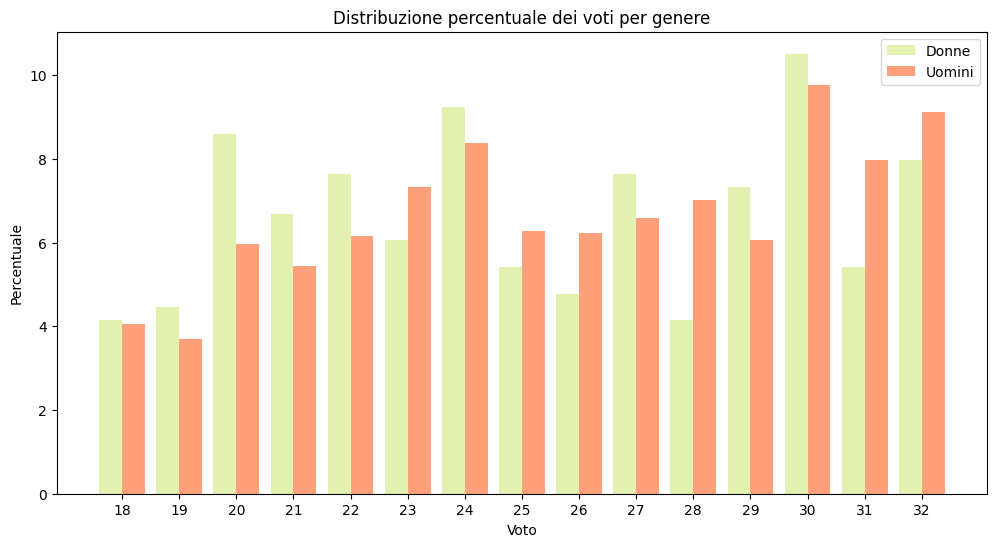

In [165]:
totale_voti_donne = len(periodo_pandemia[periodo_pandemia['GENERE'] == 'F'])
totale_voti_uomini = len(periodo_pandemia[periodo_pandemia['GENERE'] == 'M'])
voti_donne = periodo_pandemia[periodo_pandemia['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = periodo_pandemia[periodo_pandemia['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label='Donne', color='#E2F1AF')
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label='Uomini', color='#FFA07A')
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - periodo pandemia')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


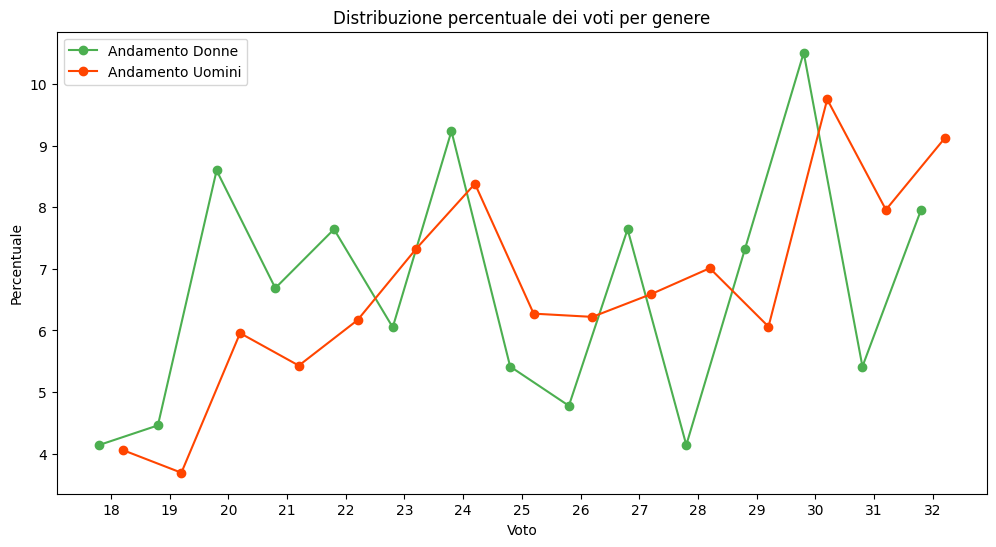

In [166]:
plt.figure(figsize=(12, 6))
plt.plot(r1, percentuale_voti_donne, marker='o', color='#4CAF50', label='Andamento Donne')
plt.plot(r2, percentuale_voti_uomini, marker='o', color='#FF4500', label='Andamento Uomini')
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - periodo pandemia')
plt.legend()
plt.show()

### Il periodo di pandemia ha inciso in generale sui singoli voti
In generale è aumentato il divario di genere guardando singolarmente i voti <br>
per le donne sono diminuiti i 18 e aumentati i 20, 22, 24 <br>
Per gli uomini sono aumentati i 32 <br>

In generale le valutazioni si sono alzate

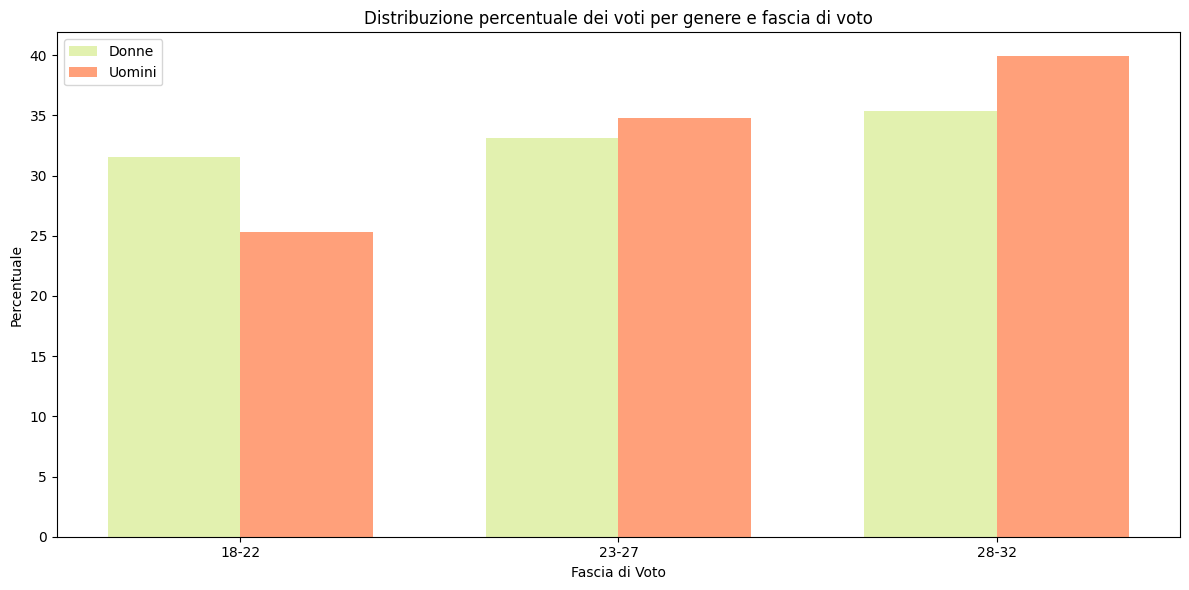

In [167]:
totale_voti = periodo_pandemia.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label='Donne', color='#E2F1AF', width=bar_width)
plt.bar(r2, percentuali_uomini, label='Uomini', color='#FFA07A', width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto - periodo pandemia')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()

raggruppando per fasce di voti, non è cambiato l'andamento nel periodo di pandemia <br>